In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os.path

cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
print(src)
print(root)
sys.path.append(str(src))
sys.path.append(str(root))

/Users/matskerver/Documents/GIT/MDP_git/Git_mdp
/Users/matskerver/Documents/GIT/MDP_git


In [2]:
from superflexpy.implementation.elements.gr4j import BaseElement, UnitHydrograph1, UnitHydrograph2, FluxAggregator 
from superflexpy.implementation.elements.gr4j import InterceptionFilter, ProductionStore, RoutingStore
from superflexpy.implementation.elements.structure_elements import Transparent, Splitter, Junction
from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network
from utils.precipitation_evaporation import *

In [70]:
def GR4J_element(x1,x2,x3,x4, name, area, precipitation, evaporation):
    #x1, x2, x3, x4 = (50.0, 0.1, 20.0, 3.5)

    root_finder = PegasusPython()  # Use the default parameters
    numerical_approximation = ImplicitEulerPython(root_finder)

    interception_filter = InterceptionFilter(id='ir')

    production_store = ProductionStore(parameters={'x1': x1, 'alpha': 2.0,
                                                   'beta': 5.0, 'ni': 4/9},
                                       states={'S0': 5.0},
                                       approximation=numerical_approximation,
                                       id='ps')

    splitter = Splitter(weight=[[0.9], [0.1]],
                        direction=[[0], [0]],
                        id='spl')

    unit_hydrograph_1 = UnitHydrograph1(parameters={'lag-time': x4},
                                        states={'lag': None},
                                        id='uh1')

    unit_hydrograph_2 = UnitHydrograph2(parameters={'lag-time': 2*x4},
                                        states={'lag': None},
                                        id='uh2')

    routing_store = RoutingStore(parameters={'x2': x2, 'x3': x3,
                                             'gamma': 5.0, 'omega': 3.5},
                                 states={'S0': 20.0},
                                 approximation=numerical_approximation,
                                 id='rs')

    transparent = Transparent(id='tr')

    junction = Junction(direction=[[0, None],  # First output
                                   [1, None],  # Second output
                                   [None, 0]], # Third output
                        id='jun')

    flux_aggregator = FluxAggregator(id='fa')

    catchment_element = Unit(layers=[[interception_filter],
                     [production_store],
                     [splitter],
                     [unit_hydrograph_1, unit_hydrograph_2],
                     [routing_store, transparent],
                     [junction],
                     [flux_aggregator]],
             id=f'unit-{name}')
    
    
    current_node = Node(
    units=[catchment_element],
    weights = [1.0],
    area=area,
    id=f'node-{name}'
    )
    
    current_node.set_input([evaporation, precipitation])
    #print(precipitation)
    return current_node

In [91]:
x1, x2, x3, x4 = 50.0, 0.1, 20., 3.5
areas = [10.0, 4.6, 2.6, 9.1,10.0, 4.6, 2.6, 9.1, 10.0, 4.6, 2.6, 9.1,10.0, 4.6, 2.6, 9.1]
years = 10

In [92]:
nodes_gr4j = []

# Creates 4 instances of the same node (but with varying precipitation and area values) to be put into the network

for i in range(16):
    name = str(i+1)
    
    #previously written function to load in some dummy rain and evaporation data.
    precipitation, evaporation = precipitation_evaporation(years, 0.2, season = True, plot = False)
    
    #evaporation = np.zeros(1825)
    if (i == 3):
        precipitation = np.zeros(years*365)  #Change the value of the 4th cell to zero to ensure that any output
        evaporation = np.zeros(years*365)    # of the cell must have come from the upstream catchments. 
    print(f'the evaporation in cell {i+1} equals {evaporation}')
    print(f'the precipitation in cell {i+1} equals {precipitation}') #print the values to verify they are correct
    current = GR4J_element(x1, x2, x3, x4, name, areas[i], precipitation, evaporation)
    nodes_gr4j.append(current)


the evaporation in cell 1 equals [7.5 0.  2.  ... 8.1 4.6 0. ]
the precipitation in cell 1 equals [0.2 0.2 0.9 ... 1.3 0.  1.2]
the evaporation in cell 2 equals [0.  1.8 4.7 ... 0.  5.4 6.7]
the precipitation in cell 2 equals [0.1 0.3 0.9 ... 0.3 0.7 0.1]
the evaporation in cell 3 equals [3.6 2.9 5.5 ... 2.1 0.  6.1]
the precipitation in cell 3 equals [0.2 0.6 0.1 ... 0.9 0.6 1.3]
the evaporation in cell 4 equals [0. 0. 0. ... 0. 0. 0.]
the precipitation in cell 4 equals [0. 0. 0. ... 0. 0. 0.]
the evaporation in cell 5 equals [2.1 2.6 4.2 ... 5.4 2.6 6.1]
the precipitation in cell 5 equals [0.3 0.6 0.1 ... 0.7 1.1 0.8]
the evaporation in cell 6 equals [1.4 7.2 0.7 ... 0.  2.3 1.7]
the precipitation in cell 6 equals [0.  0.5 0.5 ... 0.3 1.  1.4]
the evaporation in cell 7 equals [2.5 2.2 2.7 ... 6.  1.9 1.6]
the precipitation in cell 7 equals [0.8 1.1 0.6 ... 0.  0.5 0.2]
the evaporation in cell 8 equals [2.9 6.8 2.3 ... 2.9 4.7 4.8]
the precipitation in cell 8 equals [1.2 0.4 0.  ... 0

In [93]:
# The network is created by importing the list of nodes and a topology dictionary 
#is provided to indicate connections

net = Network(
    nodes=nodes_gr4j,
    topology={
        'node-1': 'node-4',
        'node-2': 'node-4',
        'node-3': 'node-4',
        'node-4': None,
        'node-5': 'node-4',
        'node-6': 'node-4',
        'node-7': 'node-4',
        'node-8': 'node-4',
        'node-9': 'node-4',
        'node-10': 'node-4',
        'node-11': 'node-4',
        'node-12': 'node-4',
        'node-13': 'node-4',
        'node-14': 'node-4',
        'node-15': 'node-4',
        'node-16': 'node-4',
    }
)

In [94]:
net.reset_states()
net.set_timestep(1.0)
output = net.get_output()
print(output)

{'node-1': [array([2.51139387, 1.55305982, 1.07875611, ..., 0.03663852, 0.03569733,
       0.03480766])], 'node-2': [array([2.51141091, 1.55311271, 1.07882786, ..., 0.02831206, 0.02771595,
       0.02714357])], 'node-3': [array([2.51139389, 1.55304261, 1.0786812 , ..., 0.03243662, 0.0316763 ,
       0.03094891])], 'node-5': [array([2.5113939 , 1.55304267, 1.07868137, ..., 0.02421068, 0.02375506,
       0.02331435])], 'node-6': [array([2.51139391, 1.55304267, 1.07868133, ..., 0.02343359, 0.02300475,
       0.02259042])], 'node-7': [array([2.5113939 , 1.55304268, 1.07868141, ..., 0.02368993, 0.02325135,
       0.0228269 ])], 'node-8': [array([2.5113939 , 1.55304266, 1.0786813 , ..., 0.02374308, 0.02330277,
       0.02287668])], 'node-9': [array([2.51139388, 1.55304255, 1.07868109, ..., 0.02756861, 0.02699652,
       0.0264573 ])], 'node-10': [array([2.51139388, 1.55304257, 1.0786811 , ..., 0.03062188, 0.02993424,
       0.02927578])], 'node-11': [array([2.5113939 , 1.55304264, 1.07879136

In [95]:
output_unit_1_node_1 = net.call_internal(id='node-1_unit-1',
                                        method='get_output',
                                        solve=False)[0]
output_unit_2_node_2 = net.call_internal(id='node-2_unit-2',
                                        method='get_output',
                                        solve=False)[0]
output_unit_3_node_3 = net.call_internal(id='node-3_unit-3',
                                        method='get_output',
                                        solve=False)[0]
output_unit_4_node_4 = net.call_internal(id='node-4_unit-4',
                                        method='get_output',
                                        solve=False)[0]




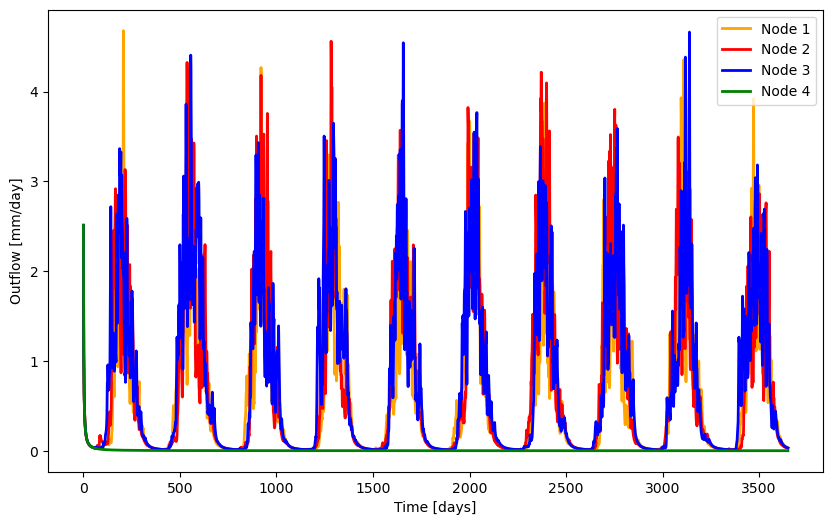

In [96]:
fig, ax = plt.subplots(figsize=(10,6))

# Plotting each node's outflow
ax.plot(range(len(output_unit_1_node_1)), output_unit_1_node_1, color='orange', lw=2, label='Node 1')
ax.plot(range(len(output_unit_2_node_2)), output_unit_2_node_2, color='red', lw=2, label='Node 2')
ax.plot(range(len(output_unit_3_node_3)), output_unit_3_node_3, color='blue', lw=2, label='Node 3')
ax.plot(range(len(output_unit_4_node_4)), output_unit_4_node_4, color='green', lw=2, label='Node 4')
#ax.plot(range(len(output)), output, color='pink', lw=2, label='Network')

ax.legend()
ax.set_xlabel('Time [days]')
ax.set_ylabel("Outflow [mm/day]")

plt.show()


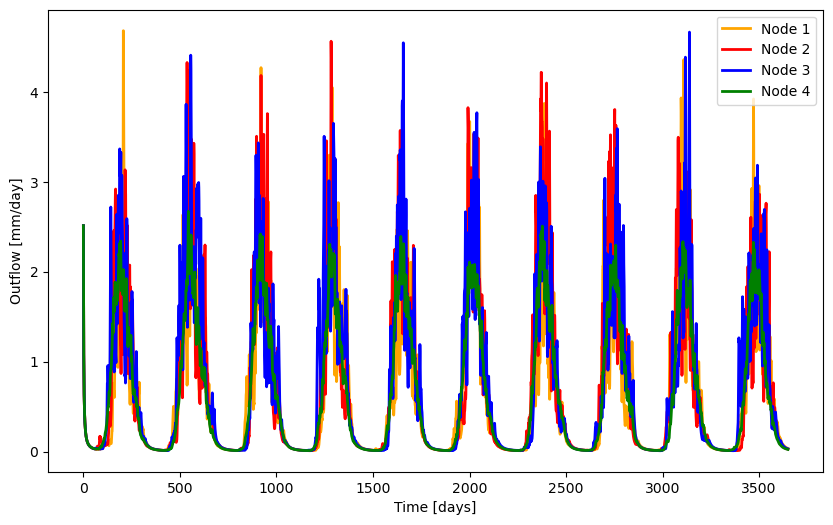

In [97]:
fig, ax = plt.subplots(figsize=(10,6))
# Plotting each node's outflow
ax.plot(range(len(output['node-1'][0])), output['node-1'][0], color='orange', lw=2, label='Node 1')
ax.plot(range(len(output['node-2'][0])), output['node-2'][0], color='red', lw=2, label='Node 2')
ax.plot(range(len(output['node-3'][0])), output['node-3'][0], color='blue', lw=2, label='Node 3')
ax.plot(range(len(output['node-4'][0])), output['node-4'][0], color='green', lw=2, label='Node 4')

ax.legend()
ax.set_xlabel('Time [days]')
ax.set_ylabel("Outflow [mm/day]")

plt.show()
